### Model Testing Notebook
This notebook is used for testing the trained model on a single image and calculating benchmarking scores. 

In [86]:
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

from utils.crf import dense_crf
from cv2 import imread, imwrite, resize

import WNet
import matplotlib.pyplot as plt
from scipy.io import loadmat

### Load WNet model
Use the correct squeeze which has been set with training the model. The model can also be loaded with CUDA optimization

In [545]:
squeeze = 6
model_path = "models/e500_idx5_sq6_lr0.06/model_e500_idx5_sq6_lr0.03"
model = WNet.WNet(squeeze)

loaded_model = torch.load(model_path, map_location=torch.device('cpu'))

model.load_state_dict(loaded_model)
model.eval()

WNet(
  (UEnc): UEnc(
    (enc1): Block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU()
      (dropout1): Dropout(p=0.0, inplace=False)
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (dropout2): Dropout(p=0.0, inplace=False)
      (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (enc2): Block(
      (spatial1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
      (depth1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (spatial2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
      (depth2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (relu1): ReLU()
      (dropout1): Dropout(p=0.0, inplace=False)
      (batchnorm1): BatchNorm2d(128

### Test on single image

In [550]:
img = Image.open("data2/images/train/8049.jpg").convert('RGB')
x = transform(img)[None, :, :, :]

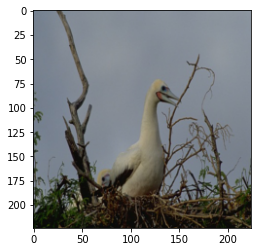

In [551]:
# Input Image
enc, dec = model(x)
show_image(x[0])

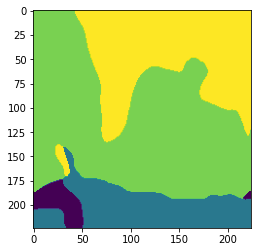

In [552]:
# Show argmax encoder output
plt.imshow(torch.argmax(enc, dim=1)[0].detach())
plt.show()

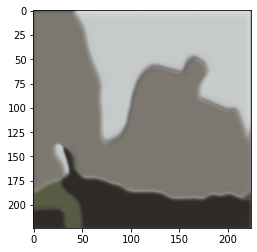

In [553]:
# Show reconstruction decoder output
show_image(dec[0].detach())

### Apply CRF Smoothing
Here the CRF smoothing is applied to the encoder output. We take the output of the CRF since this again takes the 22 segments from the encoder output

(224, 224, 3)


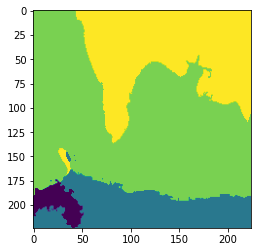

In [554]:
def load_enc_crf(img_path):
    img = Image.open(img_path).convert('RGB')
    x = transform(img)[None, :, :, :]
    enc, dec = model(x)
    segment = enc[0, :, :, :].detach()
    orimg = imread(img_path)
    img = resize(orimg, (224, 224))
    return np.argmax(dense_crf(img, segment.numpy()), axis=0)

segment_predict = load_enc_crf("data2/images/train/8049.jpg")
plt.imshow(segment_predict)

### (Optional) Making labels similar 

Since the labeling of the ground truth is a sequence of 1..n and the labeling of the encoder is more sparse. We relabel them to be a sequence of 1..n. This should not make difference but could be done. 

In [504]:
unique_values = np.unique(segment_predict)
for i in range(len(unique_values)):
    segment_predict = np.where(segment_predict==unique_values[i], i+1, segment_predict)
    
np.unique(segment_predict)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

### Load in ground truth
We load in the groundtruth of the corresponding image. We take the first segmentation to compare to the model performance.

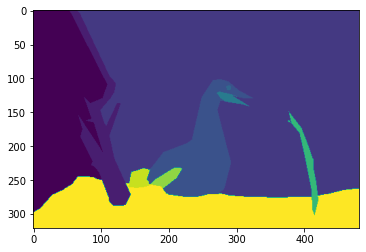

In [521]:
def load_ground_truth(gt_path):
    x = loadmat(gt_path)

    # print amount of different segmentations
    amountClasses = len(x['groundTruth'][0])
    pix_rows = len(x['groundTruth'][0][0]['Segmentation'][0][0])
    pix_columns = len(x['groundTruth'][0][0]['Segmentation'][0][0][0])

#     print("Amount of different segmentations " + str(amountClasses))
#     print("Amount of pixel rows " + str(pix_rows))
#     print("Amount of pixel columns " + str(pix_columns))

    return x['groundTruth'][0][2]['Segmentation'][0][0]
    

segment_truth = load_ground_truth('data2/groundTruth/train/8049.mat')
plt.imshow(segment_truth)

### Segmentation Covering

In [506]:
import cv2

def calculate_overlap(r1, r2):
    # intersection
    a = np.count_nonzero(r1 * r2)
    # union
    b = np.count_nonzero(r1 + r2)
    
    return a/b

def calculate_segmentation_covering(segmentation1, segmentation2):
    assert segmentation1.shape == segmentation2.shape, "segmentations should be same size"
    
    
    
    N = segmentation1.shape[0] * segmentation1.shape[1]
    
    maxcoverings_sum = 0
    
    # Sum over regions
    for label1 in np.unique(segmentation1):
        # region is where the segmentation has a specific label
        region1 = (segmentation1 == label1).astype(int) 
        # |R| is the size of nonzero elements as this the region size
        len_r = np.count_nonzero(region1) 
        max_overlap = 0
        # Calculate max overlap 
        for label2 in np.unique(segmentation2):
            # region is where the segmentation has a specific label
            region2 = (segmentation2 == label2).astype(int)
            # Calculate overlap
            overlap = calculate_overlap(region1, region2)
            max_overlap = max(max_overlap, overlap)
        
        maxcoverings_sum += (len_r * max_overlap)
        
    return (1 / N) * maxcoverings_sum

### Probabilistic Rand Index

In [507]:
import math

def calculate_probabilistic_rand_index(segmentation1, segmentation2):
    assert segmentation1.shape == segmentation2.shape, "segmentations should be same size"
    
    a1 = math.floor(segmentation1.shape[0]/10)
    a2 = math.floor(segmentation1.shape[1]/10)
    
    segmentation1 = cv2.resize(segmentation1, dsize=(a1, a2), interpolation=cv2.INTER_NEAREST)
    segmentation2 = cv2.resize(segmentation2, dsize=(a1, a2), interpolation=cv2.INTER_NEAREST)
    
    segmentation1_flat = segmentation1.flatten()
    segmentation2_flat = segmentation2.flatten()
    
    n = len(segmentation1_flat)
    m = len(segmentation2_flat)
    
    T = n * m
    
    # first calculate pixel probabilities
    prob_segment1 = {}
    for label in np.unique(segmentation1):
        prob_segment1[label] = np.count_nonzero(segmentation1 == label) / n
    
    prob_segment2 = {}
    for label in np.unique(segmentation2):
        prob_segment2[label] = np.count_nonzero(segmentation2 == label) / m
        
    rand_index_sum = 0 
    
    # Then perform main loop
    for i in range(n):
        for j in range(i,m):
            pixeli = segmentation1_flat[i]
            pixelj = segmentation2_flat[j]
            # event that pixels i and j have the same label 
            c_ij = pixeli == pixelj
            # probability that pixels i and j have the same label
            p_ij = prob_segment1[pixeli] * prob_segment2[pixelj]
            rand_index_sum += c_ij * p_ij + (1 - c_ij) * (1 - p_ij)
    
    
    return (1 / T) * rand_index_sum

### Variation of information

In [557]:
import skimage.measure
import sklearn.metrics

def calculate_variation_of_information(segmentation1, segmentation2):
    assert segmentation1.shape == segmentation2.shape, "segmentations should be same size"
    
    ret = skimage.measure.shannon_entropy(segmentation1)
    ret += skimage.measure.shannon_entropy(segmentation2)
#     print(ret)
    ret -= 2 * sklearn.metrics.mutual_info_score(segmentation1.flatten(), segmentation2.flatten())
#     print(ret)
    return ret

### Calculate for ODS (Optimal Dataset Scale) and OIS (Optimal Image Scale)

Calculating the benchmarks for ODS and OIS. However since we are downscaling on the probabilistic rand index (due to computational reasons) we choose the aspect ratios of the ODS and OIS.

For SC and PRI, higher scores are better;
for VI, a lower score is better.

In [528]:
def compute_benchmark(segment_truth, segment_predict):
    # ODS
    segment_truth_ods = cv2.resize(segment_truth, dsize=(224, 224), interpolation=cv2.INTER_NEAREST)

    sc_ods = calculate_segmentation_covering(segment_predict, segment_truth_ods)

    pri_ods = 0 # calculate_probabilistic_rand_index(segment_predict, segment_truth_ods)

    vi_ods = calculate_variation_of_information(segment_predict, segment_truth_ods)

    # OIS
    segment_predict_ois = cv2.resize(segment_predict, dsize=(segment_truth.shape[1], segment_truth.shape[0]), interpolation=cv2.INTER_NEAREST)

    sc_ois = calculate_segmentation_covering(segment_predict_ois, segment_truth)

    pri_ois = 0 # calculate_probabilistic_rand_index(segment_predict_ois, segment_truth)

    vi_ois = calculate_variation_of_information(segment_predict_ois, segment_truth)
    
    return sc_ods, pri_ods, vi_ods, sc_ois, pri_ois, vi_ois

sc_ods, pri_ods, vi_ods, sc_ois, pri_ois, vi_ois = compute_benchmark(segment_truth, segment_predict)

print("ODS:")
print("SC: " + str(sc_ods))
print("PRI: " + str(pri_ods))
print("VI: " + str(vi_ods))
print("OIS:")
print("SC: " + str(sc_ois))
print("PRI: " + str(pri_ois))
print("VI: " + str(vi_ois))

3.9706953453949203
2.833570929363477
3.968695813545299
2.828245186531554
ODS:
SC: 0.5456440381942678
PRI: 0
VI: 2.833570929363477
OIS:
SC: 0.5446828653340523
PRI: 0
VI: 2.828245186531554


### Run on all images

In [559]:
import os

# Get all the names for the test stuff
jpegs = os.listdir('data/images/test')
train_list = []
for j in jpegs:
    if ".jpg" in j:
        train_list.append(j[:-4])
        
sc_ods_list = []
pri_ods_list = []
vi_ods_list = []
sc_ois_list = []
pri_ois_list = []
vi_ois_list = []

for train_sample in train_list:
    print("Testing image and ground truth: " + train_sample)
    segmentation_predict = load_enc_crf("data/images/test/" + train_sample + ".jpg")
    segmentation_truth = load_ground_truth("data/groundTruth/test/" + train_sample + ".mat")
    sc_ods, pri_ods, vi_ods, sc_ois, pri_ois, vi_ois = compute_benchmark(segment_truth, segment_predict)    
    sc_ods_list.append(sc_ods)
    pri_ods_list.append(pri_ods)
    vi_ods_list.append(vi_ods)
    sc_ois_list.append(sc_ois)
    pri_ois_list.append(pri_ois)
    vi_ois_list.append(vi_ois)

print("ODS:")
print("SC: " + str(np.mean(sc_ods_list)))
print("PRI: " + str(np.mean(pri_ods_list)))
print("VI: " + str(np.mean(vi_ods_list)))
print("OIS:")
print("SC: " + str(np.mean(sc_ois_list)))
print("PRI: " + str(np.mean(pri_ois_list)))
print("VI: " + str(np.mean(vi_ois_list)))

Testing image and ground truth: 250087
(224, 224, 3)
Testing image and ground truth: 259060
(224, 224, 3)
Testing image and ground truth: 140006
(224, 224, 3)
Testing image and ground truth: 106047
(224, 224, 3)
Testing image and ground truth: 279005
(224, 224, 3)
Testing image and ground truth: 5096
(224, 224, 3)
Testing image and ground truth: 246009
(224, 224, 3)
Testing image and ground truth: 48017
(224, 224, 3)
Testing image and ground truth: 10081
(224, 224, 3)
Testing image and ground truth: 36046
(224, 224, 3)
Testing image and ground truth: 372019
(224, 224, 3)
Testing image and ground truth: 189013
(224, 224, 3)
Testing image and ground truth: 250047
(224, 224, 3)
Testing image and ground truth: 183066
(224, 224, 3)
Testing image and ground truth: 108069
(224, 224, 3)
Testing image and ground truth: 253016
(224, 224, 3)
Testing image and ground truth: 104055
(224, 224, 3)
Testing image and ground truth: 70011
(224, 224, 3)
Testing image and ground truth: 296028
(224, 224, 3)

(224, 224, 3)
Testing image and ground truth: 108004
(224, 224, 3)
Testing image and ground truth: 289011
(224, 224, 3)
Testing image and ground truth: 302022
(224, 224, 3)
Testing image and ground truth: 130014
(224, 224, 3)
Testing image and ground truth: 118015
(224, 224, 3)
Testing image and ground truth: 243095
(224, 224, 3)
Testing image and ground truth: 118072
(224, 224, 3)
Testing image and ground truth: 223060
(224, 224, 3)
Testing image and ground truth: 344010
(224, 224, 3)
Testing image and ground truth: 101084
(224, 224, 3)
Testing image and ground truth: 384022
(224, 224, 3)
Testing image and ground truth: 100007
(224, 224, 3)
Testing image and ground truth: 207049
(224, 224, 3)
Testing image and ground truth: 69007
(224, 224, 3)
Testing image and ground truth: 41006
(224, 224, 3)
Testing image and ground truth: 268074
(224, 224, 3)
Testing image and ground truth: 268048
(224, 224, 3)
Testing image and ground truth: 130066
(224, 224, 3)
Testing image and ground truth: 71

### Extra: Clustering segmentations
This extra part of the notebook looks at the cluster labels and clusters the labels with the closest labelling. It is not sure if the labelling corresponds to distance of the segments. Also in benchmarking it is not used therefore this is extra if one wants to use it.

23


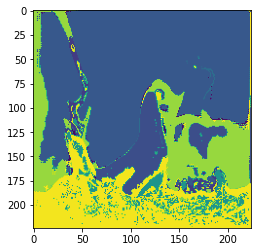

22


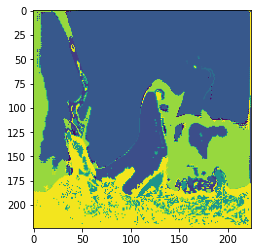

21


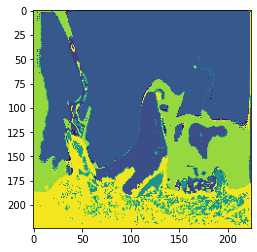

20


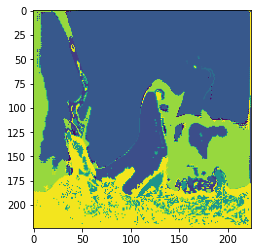

19


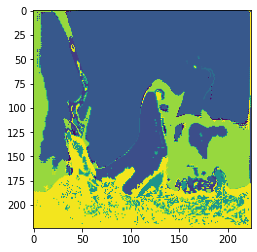

18


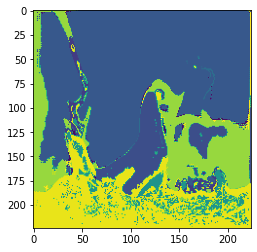

17


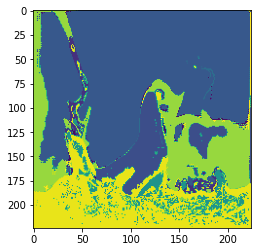

16


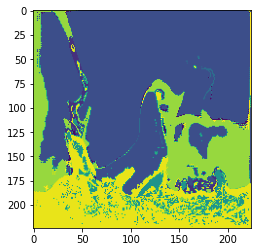

15


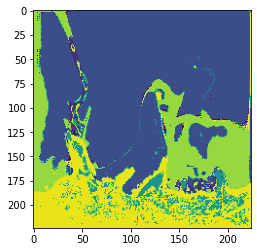

14


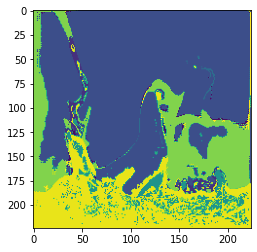

In [134]:
K = 13

def get_distance_pair(Q):
    uniq = np.unique(Q)
    label1 = uniq[0]

    if len(uniq) < 2:
        return label1, label1
    
    label2 = uniq[1]
    
    mindist = 1000
    
    for i in range(1,len(uniq)-2):
        for j in range(i+1, len(uniq)-1):
            dist = uniq[j] - uniq[i]
            if dist < mindist:
                mindist = dist
                label1 = uniq[i]
                label2 = uniq[j]
        
    return label1, label2 

while len(np.unique(Q)) > K:
    print(len(np.unique(Q)))
    label1, label2 = get_distance_pair(Q)
    Q = np.where(Q==label2, label1, Q)
    
    plt.imshow(Q)
    plt.show()

In [ ]:
###

(321, 481)
<class 'numpy.ndarray'>


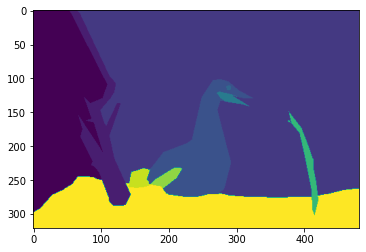

(224, 224)
<class 'numpy.ndarray'>


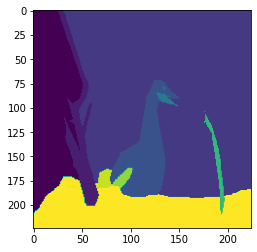

In [260]:
import cv2

plt.imshow(segment1)
print(segment1.shape)
print(type(segment1))
plt.show()

segment1 = cv2.resize(segment1, dsize=(224, 224), interpolation=cv2.INTER_NEAREST)

plt.imshow(segment1)
print(segment1.shape)
print(type(segment1))
plt.show()